In [12]:
from datasets import load_dataset

from transformers import (
    SegformerForSemanticSegmentation, 
    SegformerImageProcessor,)

import torch
from torch import nn
from torch import optim

import numpy as np

import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')
device = torch.device('cuda')

[Facade Dataset](https://huggingface.co/datasets/Xpitfire/cmp_facade)

In [69]:
DATA_PATH = "Xpitfire/cmp_facade"
facade_train = load_dataset(DATA_PATH, split="train")
facade_valid = load_dataset(DATA_PATH, split="eval")
facade_test = load_dataset(DATA_PATH, split="test")

Found cached dataset parquet (/home/m_bobrin/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/m_bobrin/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/home/m_bobrin/.cache/huggingface/datasets/Xpitfire___parquet/Xpitfire--cmp_facade-642b435710aeac91/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [50]:
# Observe that label image is stored in P mode
facade_train[0]

{'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=543x1024>,
 'label': <PIL.PngImagePlugin.PngImageFile image mode=P size=543x1024>}

In [62]:
len(facade_test)

114

## Inspecting Facade dataset 🏘

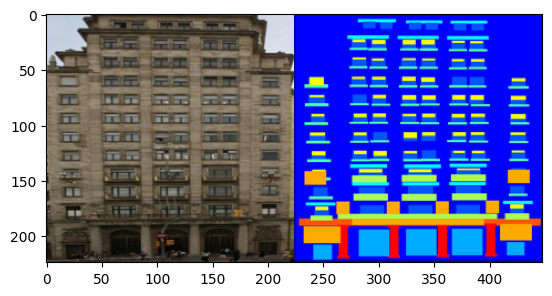

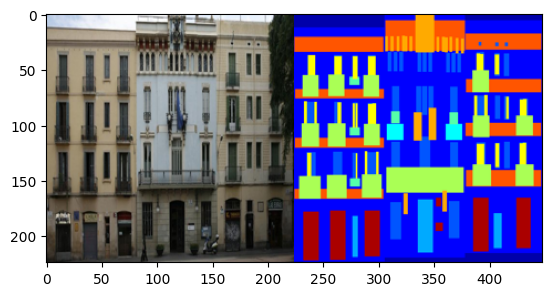

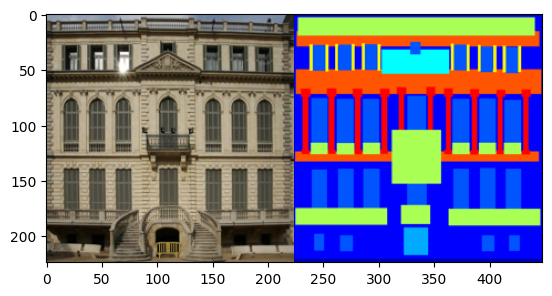

In [65]:
from PIL import Image
import matplotlib.pyplot as plt

some_indexes = [0, 2, 3]
for i in some_indexes:
    stacked_img = Image.fromarray(
                np.hstack((facade_train[i]['pixel_values'].resize((224, 224)),
                         np.asarray(facade_train[i]['label'].convert("RGB").resize((224, 224))).reshape((224, 224, 3))
    )))
    
    plt.imshow(stacked_img)
    plt.show()

## Download config from repo on hub

In [76]:
import json
from huggingface_hub import hf_hub_download

config = json.load(open(hf_hub_download(repo_id=DATA_PATH, filename="config.json", repo_type="dataset"), "r"))
id2label = config['id2label']
label2id = config['label2id']